# Mathematics for Machine Learning

## Session 26: Automatic Differentiation; Hessian Matrix

### Gerhard Jäger


February 4, 2025

---
<br><br>

<small>Most material taken from Chapter 5 of Deisenroth, Faisal & Ong's (2024) Mathematics for Machine Learning, and a lecture by J. Zico Kolter and Tianqi Chen from CMU (https://www.youtube.com/watch?v=56WUlMEeAuA&t=2198s).</small><br>
<small>Applets programmed with the help of ChatGPT and Perplexity</small>


## Numerical Differentiation

### Why Numerical Differentiation?
Numerical differentiation allows us to approximate derivatives using finite differences. It's useful when we cannot compute gradients analytically, but it is prone to numerical errors.

### Forward Difference Formula
We directly compute the partial gradient by definition:

$$
\frac{\partial f(\theta)}{\partial \theta_i} = \lim_{\epsilon \to 0} \frac{f(\theta + \epsilon e_i) - f(\theta)}{\epsilon}
$$

### Central Difference Formula (More Accurate)

$$
\frac{\partial f(\theta)}{\partial \theta_i} = \frac{f(\theta + \epsilon e_i) - f(\theta - \epsilon e_i)}{2\epsilon} + o(\epsilon^2)
$$



- Suffers from numerical error
- Less efficient to compute compared to automatic differentiation


In [2]:
import numpy as np
from math import exp

def f(x):
    return x**2 + np.exp(x)

def forward_difference(x, epsilon):
    return (f(x + epsilon) - f(x)) / epsilon

def central_difference(x, epsilon):
    return (f(x + epsilon) - f(x - epsilon)) / (2 * epsilon)

# Compute and compare forward vs. central differences
x = 1.0
epsilon = 1e-5
print("Forward Difference:", forward_difference(x, epsilon))
print("Central Difference:", central_difference(x, epsilon))
print("Analytic Solution: ", 2+exp(1.0))

Forward Difference: 4.718305419970648
Central Difference: 4.71828182850853
Analytic Solution:  4.718281828459045



### Visual Comparison of Error


<img src="_img/approximations.svg"  width="2000" style="display: block; margin-left: auto; margin-right: auto;">
(source: https://huggingface.co/blog/andmholm/what-is-automatic-differentiation)

<img src="_img/errors.svg"  width="2000" style="display: block; margin-left: auto; margin-right: auto;">
(source: https://huggingface.co/blog/andmholm/what-is-automatic-differentiation)

## Numerical Gradient Checking

However, numerical differentiation is a powerful tool to check an implementation of an automatic differentiation algorithm in unit test cases.

$$
\delta^T \nabla_\theta f(\theta) = \frac{f(\theta + \epsilon \delta) - f(\theta - \epsilon \delta)}{2 \epsilon} + o(\epsilon^2)
$$

---

- Pick $\delta$ from the unit ball
- Check the above invariance


## Symbolic Differentiation

Write down the formulas, derive the gradient by sum, product, and chain rules:

$$
\frac{\partial (f(\theta) + g(\theta))}{\partial \theta} = \frac{\partial f(\theta)}{\partial \theta} + \frac{\partial g(\theta)}{\partial \theta}
$$

$$
\frac{\partial (f(\theta) g(\theta))}{\partial \theta} = g(\theta) \frac{\partial f(\theta)}{\partial \theta} + f(\theta) \frac{\partial g(\theta)}{\partial \theta}
$$

$$
\frac{\partial f(g(\theta))}{\partial \theta} = \frac{\partial f(g(\theta))}{\partial g(\theta)} \frac{\partial g(\theta)}{\partial \theta}
$$

---

Naively doing this can result in wasted computations.

**Example:**

$$
f(\theta) = \prod_{i=1}^{n} \theta_i
$$

$$
\frac{\partial f(\theta)}{\partial \theta_k} = \prod_{j \ne k}^{n} \theta_j
$$

Cost: $n(n - 2)$ multiplies to compute all partial gradients.


In [3]:
from sympy import symbols, sqrt, exp, cos, diff, simplify

# Define the variable x
x = symbols('x')

# Define the function f(x)
f = sqrt(x**2 + exp(x**2)) + cos(x**2 + exp(x**2))

# Compute the derivative of f(x) with respect to x
f_prime = diff(f, x)

# Display the result
f_prime



-(2*x*exp(x**2) + 2*x)*sin(x**2 + exp(x**2)) + (x*exp(x**2) + x)/sqrt(x**2 + exp(x**2))

In [4]:
simplify(f_prime)


x*(-2*sqrt(x**2 + exp(x**2))*(exp(x**2) + 1)*sin(x**2 + exp(x**2)) + exp(x**2) + 1)/sqrt(x**2 + exp(x**2))

In [5]:
f_prime.evalf(subs={x: -1})

-5.98308259590870

### another example

$$
f(x) = \frac{e^{wx+b}+ e^{-(wx + b)}}{e^{wx+b}- e^{-(wx + b)}}
$$

In [6]:
from sympy import symbols, sqrt, exp, cos, diff, simplify

x, w, b = symbols("x w b")

(exp(w*x+b)+exp(-(w*x + b)))/(exp(w*x+b)-exp(-(w*x + b)))

(exp(-b - w*x) + exp(b + w*x))/(-exp(-b - w*x) + exp(b + w*x))

In [7]:
diff((exp(w*x+b)+exp(-(w*x + b)))/(exp(w*x+b)-exp(-(w*x + b))), x)

(-w*exp(-b - w*x) - w*exp(b + w*x))*(exp(-b - w*x) + exp(b + w*x))/(-exp(-b - w*x) + exp(b + w*x))**2 + (-w*exp(-b - w*x) + w*exp(b + w*x))/(-exp(-b - w*x) + exp(b + w*x))

In [8]:
simplify(diff((exp(w*x+b)+exp(-(w*x + b)))/(exp(w*x+b)-exp(-(w*x + b))), x))

-4*w*exp(2*b + 2*w*x)/(-2*exp(2*b + 2*w*x) + exp(4*b + 4*w*x) + 1)

### No control flow

In [9]:
from sympy import symbols, sqrt, exp, cos, diff, simplify

x = symbols('x')

def f(x):
    if x > 2:
        return x*2+5
    return x / 2 + 5

diff(f, x)


/home/gjaeger/miniconda3/envs/math_ml_24/lib/python3.9/site-packages/sympy/core/function.py:1247: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'<function f at 0x7c3887587940>'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  expr = sympify(expr)


SympifyError: Sympify of expression 'could not parse '<function f at 0x7c3887587940>'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)

## Computational Graph

Consider the function

$$
f(x) = \sqrt{x^2+\exp(x^2)} + \cos(x^2+\exp(x^2))
$$

Using intermediate variables, we can implement this using **intermediate variables**, avoiding duplicate computations:
$$
\begin{align}
a &= x^2\\
b &= \exp(a)\\
c &= a + b\\
d &= \sqrt c\\
e &= \cos(c)\\
f &= d + e
\end{align}
$$

This structure of the computation can be represented as a **computational graph**, which is a **DAG** (Directed Acyclic Graph).

<img src="_img/computational_graph.svg"  width="2000" style="display: block; margin-left: auto; margin-right: auto;">


Each node (yellow circles) represents an (intermediate) value in the computation. Edges (labeled with blueish rectangles) represent input-output relations.

<img src="_img/computational_graph.svg"  width="1000" style="display: block; margin-left: auto; margin-right: auto;">

Suppose $x=-1$. Then we can compute the *forward trace* step by step:

$$
\begin{align}
a &= 1\\
b &= 2.718\\
c &= 3.718\\
d &= 1.928\\
e &= \cos(1) \approx -0.838\\
f &\approx 1.090
\end{align}
$$


### Forward Mode Automatic Differentiation

In either case, we first compute the value of each node in the computational graph, starting from the inputs and ending with the output.

In **Forward Mode AD**, we compute the global derivatives by working our way recursively forward, from the input(s) to the output.

$\to\to\to\to\to\to\to\to\to\to\to\to\to\to\to\to\to\to\to$

<img src="_img/computational_graph.svg"  width="1000" style="display: block; margin-left: auto; margin-right: auto;">

Now define 
$$
\dot v = \frac{\partial v}{\partial x}
$$
(In the example we have ultimately only one input, but in the general case there are many.)

We can then computer $\dot v$ iteratively in the *forward topological order* of the computational graph.

$$
\begin{array}[lllll]
\dot a &= 2x &= -2\\
\dot b &= \dot a\exp(a) &= -5.437\\
\dot c &= \dot a + \dot b &= -7.437\\
\dot d &= \dot c\frac{1}{2d} &= -1.928\\
\dot e &= \dot c (-\sin(c)) &= -4.055\\
\dot f &= \dot d + \dot e &= -5.983
\end{array}
$$



### Limitations of Forward Mode AD

For $f:\mathbb R^n \mapsto R^k$, we need $n$ forward passes to get the derivative with respect to each input.

We mostly care about cases where $k=1$ and $n$ is large.

In this scenario, Forward Mode AD is very inefficient.

### Reverse mode Automatic Differentiation

In **Reverse Mode AD**, we start with the output and compute the derivatives recursively while moving backward through the graph, ending with the inputs.

$\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow$

<img src="_img/computational_graph.svg"  width="1000" style="display: block; margin-left: auto; margin-right: auto;">

Here we work our way backward through the graph. We define and **adjoint** for each node, which is the the partial derivative of the output against this node:

$$
\bar{v}_i = \frac{\partial f}{\partial v_i}
$$


For the example we get

$$
\begin{array}{lllll}
\bar{f} &= 1\\
\bar{e} &= 1\\
\bar{d} &= 1\\
\bar{c} &= \frac{\partial d}{\partial c}\bar{d} + \frac{\partial e}{\partial c}\bar{e} &= \frac{1}{2d}-\sin(c) &= 0.805\\
\bar{b} &= \frac{\partial c}{\partial b}\bar{c} &&= 0.805\\
\bar{a} &= \frac{\partial c}{\partial a}\bar{c} + \frac{\partial b}{\partial a}\bar{b} &= \bar{c} + b\bar{b}&= 2.991\\
\bar{x} &= \frac{\partial a}{\partial x}\bar{a} &= 2x\bar{a} &=-5.983
\end{array}
$$


**Backpropagation** is nothing else than Reverse Mode AD, applied to artificial neural networks.

### Implementation of Reverse Mode AD

**partial adjoints** are the components of the inner product when applying the multivariate chain rule.

$$
\bar{v}_{i \to j} = \bar{v_j}\frac{\partial v_j}{\partial v_i}
$$

### Reverse AD algorithm
- **node\_to\_grad = {out: [1]}**  

- **for $i$ in reverse\_topo\_order(out):**
  - $\bar{v}_i = \sum_j \bar{v}_{i \to j} = \text{sum(node_to_grad[i])}$

  - for $k$ in inputs($i$):
    - **compute $\bar{v}_{k \to i} = \bar{v}_i \cdot \frac{\partial v_i}{\partial v_k}$**  
    - **append $\bar{v}_{k \to i}$ to node\_to\_grad[k]**

- **return adjoint of input $\bar{v}_{\text{input}}$**


**Explanation**

- The algorithm works by traversing nodes in reverse topological order.
- Partial adjoints are computed and accumulated for each node.
- These partial adjoints are propagated backwards to the node’s inputs.



## Handling Control Flow in AD

Automatic differentiation can handle control flow, such as conditionals and loops, by dynamically building the computational graph during execution.

For example:

```{python}
# A function with conditional control flow
def f(x):
    if x > 0:
        return x**2
    else:
        return -x**2

# Forward mode AD will execute both branches depending on the input
x = 2.0  # Test input
```

- The computational graph adapts based on the executed branch.
- This allows AD frameworks to correctly compute derivatives even with complex control flow.



### Reverse Mode and Control Flow

In reverse mode AD, the control flow must be **recorded** during the forward pass and **replayed** during the backward pass.

Example:


```{python}
def g(x):
    y = 0
    for i in range(int(x)):
        y += i * x
    return y

# Reverse mode records the loop's iterations and dependencies
```

- The graph includes nodes for each iteration of the loop.
- During the backward pass, gradients are computed by propagating through these nodes.

**Key Point:** Both forward and reverse modes can handle loops, conditionals, and recursion, provided the control flow is differentiable.



## Summary of Differentiation Methods

| **Method**          | **Description**                                     | **Efficiency**                     | **Use Case**                                |
|---------------------|-----------------------------------------------------|--------------------------------------|----------------------------------------------|
| Numerical           | Approximate using finite differences                | Inefficient, error-prone             | Gradient checking, simple computations       |
| Symbolic            | Compute exact formulas for derivatives              | Can be inefficient due to expression swelling | Small, algebraic functions                   |
| Forward Mode AD     | Propagate derivatives along the computational graph | Efficient for small input sizes      | Jacobian-vector products                     |
| Reverse Mode AD     | Backpropagate derivatives from output to input      | Efficient for large input dimensions | Neural networks, optimization problems       |


# Multivariate higher derivatives

As with standard derivatives, we can iterate partial derivatives

$$
\frac{\partial^2 x}{\partial y^2} = \frac{\partial \frac{\partial x}{y}}{\partial y}
$$

What is new: we can use different variables for iterated derivatives

$$
\begin{align}
\frac{\partial^2 x}{\partial y\partial z} &= \frac{\partial \frac{\partial x}{y}}{\partial z}\\
\frac{\partial^2 x}{\partial z\partial y} &= \frac{\partial \frac{\partial x}{z}}{\partial y}\\
\end{align}
$$


### Example

$$
\begin{align}
z &= e^x \sin y + xy^2\\
\frac{\partial z}{\partial x} &= e^x\sin y + y^2\\
\frac{\partial z}{\partial y} &= e^x\cos y + 2xy\\
\frac{\partial^2 z}{\partial x^2} &= e^x\sin y\\
\frac{\partial^2 z}{\partial y^2} &= -e^x\sin y + 2x\\
\frac{\partial^2 z}{\partial x\partial y} &= e^x\cos y + 2y\\
\frac{\partial^2 z}{\partial y\partial x} &= e^x\cos y + 2y\\
\end{align}
$$

Conspicuously, it holds that

$$
\frac{\partial^2 z}{\partial x\partial y} = \frac{\partial^2 z}{\partial y\partial x}
$$

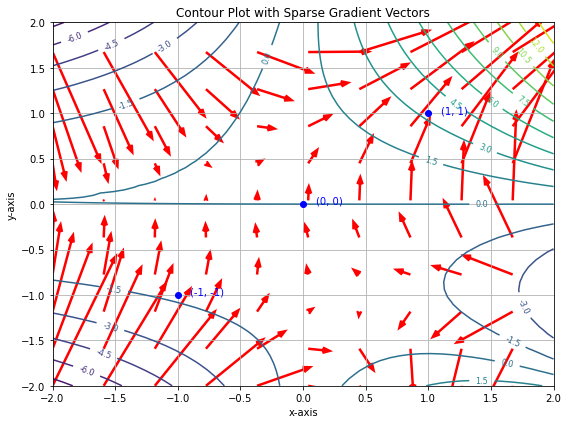

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function and its partial derivatives
def example_function(x, y):
    return np.exp(x) * np.sin(y) + x * y**2

def gradient_x(x, y):
    return np.exp(x) * np.sin(y) + y**2

def gradient_y(x, y):
    return np.exp(x) * np.cos(y) + 2 * x * y

# Generate grid points
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
Z = example_function(X, Y)

# Calculate gradients for vector field arrows
grad_X = gradient_x(X, Y)
grad_Y = gradient_y(X, Y)

# Reduce the density of arrows for clarity
arrow_density = 5
X_sparse, Y_sparse = X[::arrow_density, ::arrow_density], Y[::arrow_density, ::arrow_density]
grad_X_sparse, grad_Y_sparse = grad_X[::arrow_density, ::arrow_density], grad_Y[::arrow_density, ::arrow_density]

# Plot the contour map with sparse gradients
fig, ax = plt.subplots(figsize=(8, 6))

# Contour plot
contour = ax.contour(X, Y, Z, levels=20, cmap='viridis')
ax.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

# Add sparse gradient vectors
ax.quiver(X_sparse, Y_sparse, grad_X_sparse, grad_Y_sparse, color='red', scale=30, headwidth=3, headlength=4, width=0.005)

# Mark and label key points
key_points = [(0, 0), (1, 1), (-1, -1)]
for x_pt, y_pt in key_points:
    ax.plot(x_pt, y_pt, 'bo')
    ax.text(x_pt + 0.1, y_pt, f'({x_pt}, {y_pt})', color='blue')

# Customize plot
ax.set_title('Contour Plot with Sparse Gradient Vectors')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.grid(True)

plt.tight_layout()
plt.show()


**THEOREM (Equality of Mixed Partials)**

*Suppose that the first and second partial derivatives of $z=f(x,y)$ are continuous at $(a,b)$. Then at $(a,b)$,*

$$
\frac{\partial^2 z}{\partial x\partial y} = \frac{\partial^2 z}{\partial y\partial x}
$$

This result is not very intuitive, but still very convenient. Note that the continuity condition (which is even stronger than smoothness) is crucial.

The proof of this theorem goes beyond the scope of this course. (See Keisler, Chapter 11, if you want to see the details.)

# The Hessian Matrix: Definition

- The **Hessian matrix** is a square matrix of second-order partial derivatives for a multivariate function.
- Given a function $f(x_1, x_2, \dots, x_n)$, the Hessian matrix is defined as:

$$
H(f) = 
\begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}
$$

- The Hessian provides information about the curvature of a function at a point, helping to classify critical points as minima, maxima, or saddle points.


# The Hessian Matrix: Properties

- The **Hessian matrix** is **symmetric** if all second-order partial derivatives are continuous:

$$
\frac{\partial^2 f}{\partial x_i \partial x_j} = \frac{\partial^2 f}{\partial x_j \partial x_i}
$$

- The Hessian provides information about the **curvature** of a function at a point:
  - **Positive definite**: All eigenvalues are positive, indicating a **local minimum**.
  - **Negative definite**: All eigenvalues are negative, indicating a **local maximum**.
  - **Indefinite**: The eigenvalues have mixed signs, indicating a **saddle point**.

- The eigenvalues and eigenvectors of the Hessian describe the **direction and magnitude** of maximum and minimum curvature at a point.


# The Hessian Matrix: Example

Consider the function $f(x, y) = x^3 + 3xy + y^2$. Let's calculate the Hessian matrix:

1. **First-order partial derivatives**:
   $$
   \frac{\partial f}{\partial x} = 3x^2 + 3y, \quad \frac{\partial f}{\partial y} = 3x + 2y
   $$

2. **Second-order partial derivatives**:
   $$
   \frac{\partial^2 f}{\partial x^2} = 6x, \quad \frac{\partial^2 f}{\partial y^2} = 2, \quad \frac{\partial^2 f}{\partial x \partial y} = \frac{\partial^2 f}{\partial y \partial x} = 3
   $$
   
3. **Gradient**:

$$
\nabla f = \begin{bmatrix}
3x^2 + 3y & 3x+2y
\end{bmatrix}
$$

4. **Hessian matrix**:
   $$
   H(f) = \begin{bmatrix} 6x & 3 \\ 3 & 2 \end{bmatrix}
   $$


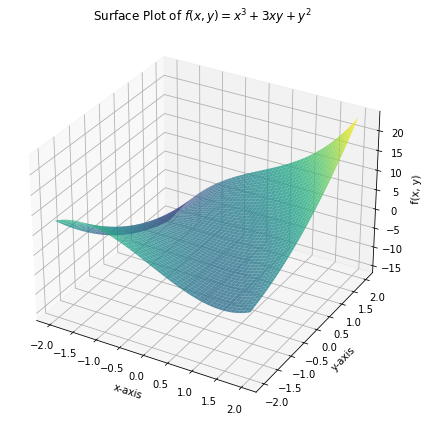

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def example_function(x, y):
    return x**3 + 3 * x * y + y**2

# Generate mesh grid for plotting
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
Z = example_function(X, Y)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_title("Surface Plot of $f(x, y) = x^3 + 3xy + y^2$")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("f(x, y)")

plt.tight_layout()
plt.show()


## Finding extreme points

At an (interior) global maximum, the gradient is 0, and the Hessian is negative definite.

At an (interior) global minimum, the gradient is 0, and the Hessian is positive definite.

(Note the analogy to the univariate case: derivative $\approx$ gradient; second derivative $\approx$ Hessian)


**Step 1: Set the gradient to 0**

$$
\begin{align}
\nabla f = \begin{bmatrix}
3x^2 +2y& 3x+2y
\end{bmatrix} &= 0\\
 3x^2 +3y&= 0\\
 3x+2y &= 0\\
 x &= -\frac{2}{3}y\\
 3(-\frac{2}{3}y)^2 + 3(-\frac{2}{3}y) &= 0\\
 \frac{4}{3}y -2y &= 0\\
 y &= 0\\
 x &= 0
\end{align}
$$





**Step 2: Compute the Hessian**

$$
\left.H(f)\right|_{(x,y) = 0} = \left.\begin{bmatrix} 6x & 3 \\ 3 & 2 \end{bmatrix}\right|_{(x,y) = 0} = \begin{bmatrix} 0 & 3 \\ 3 & 2 \end{bmatrix}
$$

**Step 3: Determine eigenvalues**

In [3]:
import sympy as sp

H = sp.Matrix([
    [0, 3],
    [3,2]
])
H

Matrix([
[0, 3],
[3, 2]])

In [8]:
list(H.eigenvals().keys())

[1 - sqrt(10), 1 + sqrt(10)]

Since one eigenvalue is positive and the other is negative, the point $(0,0)$ is neither a maximum nor a minimum.